# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [18]:
import requests

url = "https://en.wikipedia.org/wiki/List_of_Spotify_streaming_records"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

response = requests.get(url, headers=headers)

html_content = response.text
print("Status:", response.status_code)
print("HTML length:", len(html_content))



Status: 200
HTML length: 681362


In [19]:
print(html_content[:2000])

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" lang="en" dir="ltr">
<head>
<meta charset="UTF-8">
<title>List of Spotify streaming records - Wikipedia</title>
<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-

In [21]:
from bs4 import BeautifulSoup
import pandas as pd

soup = BeautifulSoup(html_content, "html.parser")

tables = soup.find_all("table", class_="wikitable")

print("Número de tablas encontradas:", len(tables))

if len(tables) == 0:
    raise ValueError("Wikipedia devolvió un HTML sin tablas (modo móvil). Cambia User-Agent.")

# Extraemos la primera tabla estática
df = pd.read_html(str(tables[0]))[0]

df.head()


Número de tablas encontradas: 26


/tmp/ipykernel_5198/2395504315.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables[0]))[0]


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.135,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.641,6 January 2017,[2]
2,3,"""Starboy""",The Weeknd and Daft Punk,4.202,21 September 2016,[3]
3,4,"""Sweater Weather""",The Neighbourhood,4.171,3 December 2012,[4]
4,5,"""Someone You Loved""",Lewis Capaldi,4.127,8 November 2018,[5]


In [25]:
df.columns = [
    "Rank",
    "Song",
    "Artist(s)",
    "Streams (billions)",
    "Release date",
    "Ref"
]

df.head()


,Rank,Song,Artist(s),Streams (billions),Release date,Ref
0,1,"""Blinding Lights""",The Weeknd,5.135,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.641,6 January 2017,[2]
2,3,"""Starboy""",The Weeknd and Daft Punk,4.202,21 September 2016,[3]
3,4,"""Sweater Weather""",The Neighbourhood,4.171,3 December 2012,[4]
4,5,"""Someone You Loved""",Lewis Capaldi,4.127,8 November 2018,[5]


In [27]:
import re
import pandas as pd

# Extraer solo números y puntos (sin texto)
def extract_number(x):
    match = re.search(r"\d+\.\d+|\d+", str(x))  # busca 5.135 o 5
    return float(match.group()) if match else None

df["Streams (billions)"] = df["Streams (billions)"].apply(extract_number)

# Convertir Rank a número
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")

# Eliminar filas sin número de streams
df = df.dropna(subset=["Streams (billions)"])

df.head()



,Rank,Song,Artist(s),Streams (billions),Release date,Ref
0,1.0,"""Blinding Lights""",The Weeknd,5.135,29 November 2019,[1]
1,2.0,"""Shape of You""",Ed Sheeran,4.641,6 January 2017,[2]
2,3.0,"""Starboy""",The Weeknd and Daft Punk,4.202,21 September 2016,[3]
3,4.0,"""Sweater Weather""",The Neighbourhood,4.171,3 December 2012,[4]
4,5.0,"""Someone You Loved""",Lewis Capaldi,4.127,8 November 2018,[5]


In [28]:
import sqlite3

# Crear/conectar a la base de datos
conn = sqlite3.connect("spotify_streaming_records.db")

# Guardar la tabla
df.to_sql("most_streamed_songs", conn, if_exists="replace", index=False)

# Guardar cambios
conn.commit()
conn.close()

print("Base de datos 'spotify_streaming_records.db' creada y datos insertados correctamente.")


Base de datos 'spotify_streaming_records.db' creada y datos insertados correctamente.


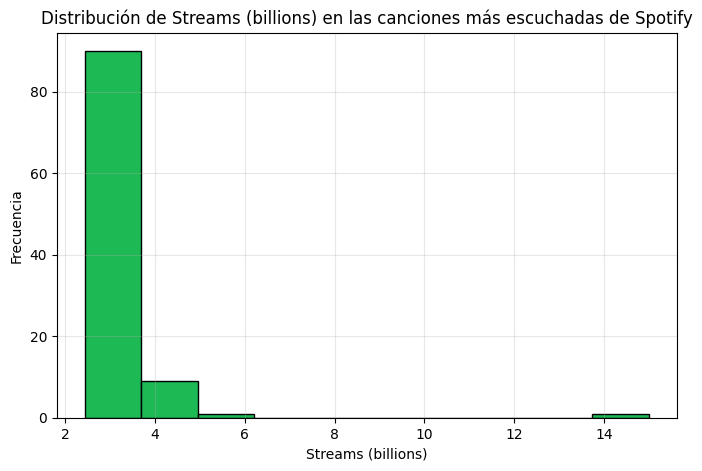

In [29]:
plt.figure(figsize=(8,5))
df["Streams (billions)"].plot(kind="hist", bins=10, color="#1DB954", edgecolor="black")
plt.title("Distribución de Streams (billions) en las canciones más escuchadas de Spotify")
plt.xlabel("Streams (billions)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()


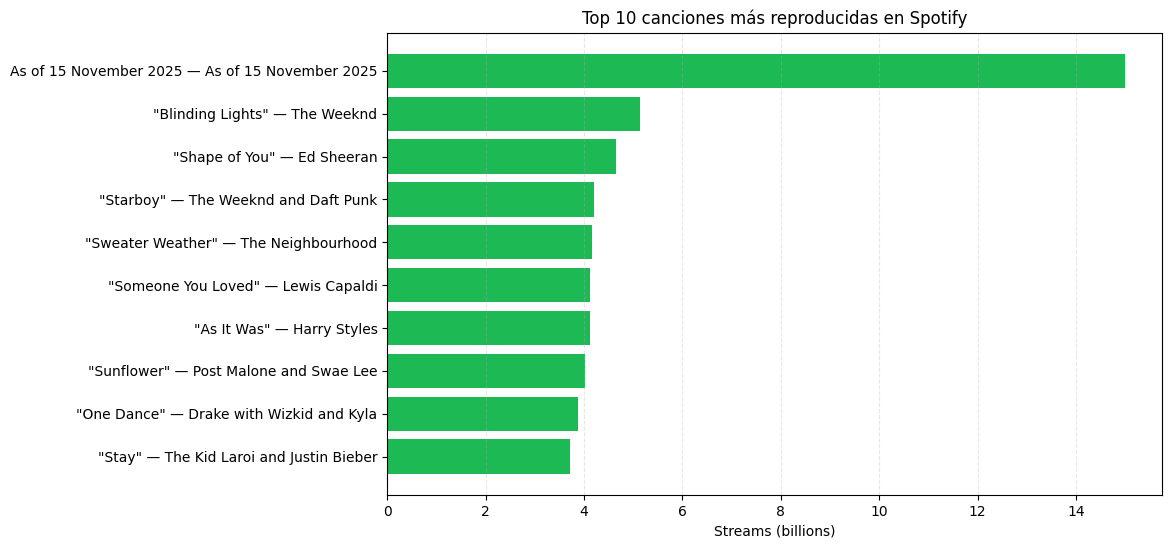

In [30]:
top10 = df.sort_values(by="Streams (billions)", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(
    top10["Song"] + " — " + top10["Artist(s)"],
    top10["Streams (billions)"],
    color="#1DB954"
)
plt.gca().invert_yaxis()
plt.title("Top 10 canciones más reproducidas en Spotify")
plt.xlabel("Streams (billions)")
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.show()


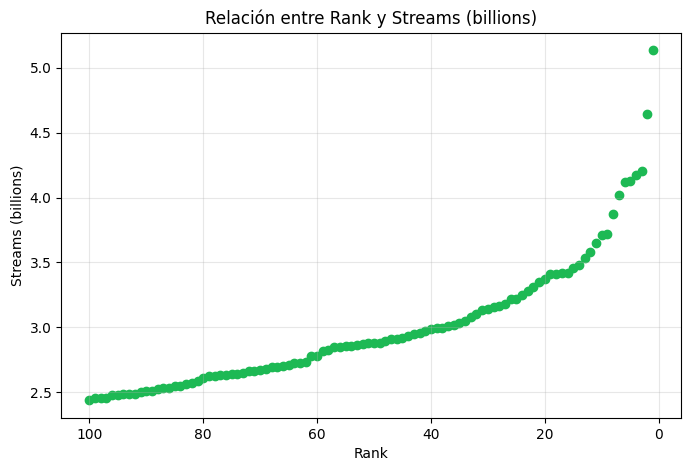

In [31]:
plt.figure(figsize=(8,5))
plt.scatter(df["Rank"], df["Streams (billions)"], color="#1DB954")
plt.title("Relación entre Rank y Streams (billions)")
plt.xlabel("Rank")
plt.ylabel("Streams (billions)")
plt.gca().invert_xaxis()  # Rank 1 a la izquierda
plt.grid(True, alpha=0.3)
plt.show()
